# Import and clean data

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [67]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
    data, test_size=0.40, random_state=42)

In [68]:
train.shape

(48000, 89)

In [69]:
train.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
id                int64
loan_default      int64
AP001             int64
                 ...   
CD170           float64
CD172           float64
CD173           float64
MB005           float64
MB007            object
Length: 89, dtype: object

In [70]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0,int64
Unnamed: 0.1,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [71]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [72]:
var.columns = ['varname','dtype']
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [73]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [74]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
MB     2
Un     2
lo     1
id     1
Name: source, dtype: int64

In [75]:
var['source'].value_counts()
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source'] == 'MB']['varname'])
AP_list = list(var[(var['source'] == 'AP') & (var['varname'] != 'AP004')]['varname'])
TD_list = list(var[var['source'] == 'TD']['varname'])
CR_list = list(var[var['source'] == 'CR']['varname'])
PA_list = list(var[var['source'] == 'PA']['varname'])
CD_list = list(var[var['source'] == 'CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [76]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

In [77]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list
target='loan_default'

Import h2o and transform dataset to h2o frame

In [78]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 11 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_emilyziyixiao_zm95ip
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.701 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [79]:
#train_smpl = train.sample(frac=0.1, random_state=1)
#test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# GLM

 The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

In [81]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

# split into train and validation sets
train, valid= train_hex.split_frame(ratios = [.8])

# select the values for lambda_ to grid over
hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]}

# this example uses cartesian grid search because the search space is small
# and we want to see the performance of all models. For a larger search space use
# random grid search instead: {'strategy': "RandomDiscrete"}
# initialize the glm estimator
glm = H2OGeneralizedLinearEstimator(family = 'binomial')

# build grid search with previously made GLM and hyperparameters
grid = H2OGridSearch(model = glm, hyper_params = hyper_params,
                     search_criteria = {'strategy': "RandomDiscrete"})

# train using the grid
grid.train(x = predictors, y = target, training_frame = train, validation_frame = valid)

# sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by = 'auc', decreasing = True)
print(sorted_grid)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by decreasing auc
    lambda    model_ids                                                       auc
--  --------  --------------------------------------------------------------  --------
    0.001     Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_4  0.658375
    0.01      Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_6  0.658134
    0.0001    Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_2  0.656961
    1e-05     Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_8  0.655459
    0         Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_1  0.654466
    0.1       Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_3  0.609234
    0.5       Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model_5  0.5
    1         Grid_GLM_py_84_sid_8592_model_python_1669964698126_173_model

By using grid search, we can find the best lambda for this model. The table above shows the sorted hyper-parameter, which tells us that the auc is the highest when lambda = 0.001. Next we build a GLM model using 0.001 to set lambda.

In [82]:
glm_final = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001)

# then train your model
glm_final.train(x = predictors, y = target, training_frame = train, validation_frame = valid)

# print the auc for the validation data
print(glm_final.auc(valid=True))

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
0.6583745495501984


Here we can see that the AUC value of the model is 0.658.

In [83]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

In [93]:
createGains(glm_final)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,934,2266,3200,934,2266,0.15,0.09,622.4,1.50,6.0,29.19
1,3200,891,2309,6400,1825,4575,0.29,0.18,1244.8,1.47,11.0,28.52
2,3200,931,2269,9600,2756,6844,0.44,0.27,1867.2,1.48,17.0,28.71
3,3200,813,2387,12800,3569,9231,0.57,0.36,2489.6,1.43,21.0,27.88
4,3200,457,2743,16000,4026,11974,0.65,0.46,3112.0,1.29,19.0,25.16
5,3200,423,2777,19200,4449,14751,0.71,0.57,3734.4,1.19,14.0,23.17
6,3200,430,2770,22400,4879,17521,0.78,0.68,4356.8,1.12,10.0,21.78
7,3200,474,2726,25600,5353,20247,0.86,0.79,4979.2,1.08,7.0,20.91
8,3200,441,2759,28800,5794,23006,0.93,0.89,5601.6,1.03,4.0,20.12


This is the gains table for GLM model. We can see the gains and lifts in the table, both in decending order.

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



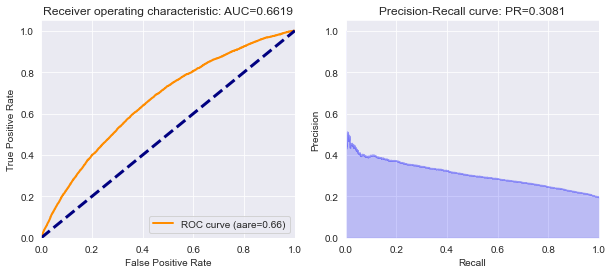

In [94]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df[predictors]).as_data_frame()
    y_pred = y_pred['p1']
    fpr = list()
    tpr = list()
    roc_auc = list()
    #print(y_actual)
    #print(y_pred)
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

ROC_AUC(glm_final,test_hex,'loan_default')

This is a visualization of AUC and precision-recall curve. Since we have used grid search to find the best lambda, both values are relatively better performing than other lambda values.

# AutoML

AutoML performs a hyperparameter search over a variety of H2O algorithms in order to deliver the best model. It can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit.

In [14]:
from h2o.automl import H2OAutoML

Run autoML model with cross validation

In [25]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |
03:22:34.14: _train param, Dropping bad and constant columns: [CR012, AP005, TD062]
03:22:34.14: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████████████████
03:22:50.497: _train param, Dropping bad and constant columns: [TD062, CR012, TD029, TD028, TD027, TD026, TD025, AP005]
03:22:50.497: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
03:22:51.221: _train param, Dropping bad and constant columns: [CR012, AP005, TD062]
03:22:51.221: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categori

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_1_AutoML_2_20221202_32233


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 1,711 weights/biases, 32.3 KB, 335,860 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms                momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ----------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        147      Input      0.0
    2        10       Rectifier  0.0        0.0   0.0   0.16427881360811508    0.3751875162124634      0.0         0.0060602131320809435  0.12458440661430359  0.46983656911796967  0.11291623115539551
    3        10       Rectifier  0.0        0.0   0.0   0.0018846458365442231  0.0009857076220214367   0.0         -0.03137545197270811   0.3580653667449951   0.9186796840840976   0.11160704493522644
    4        10       Rectifier  0.0        0.0   0.0   0.01546950667645433    0.034689053893089294    0.0         -0.13091060780454428   0.28564929962158203  0.8942285099062959   0.1167992651462555
    5        1        Linear                0.0   0.0   0.0007361323456279934  0.00042628601659089327  0.0         0.10276693138148403    0.26451539993286133  0.3228509980764521   1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.14672283979708275
RMSE: 0.3830441747332581
MAE: 0.28532484165962313
RMSLE: 0.26733475415500574
Mean Residual Deviance: 0.14672283979708275

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.14714581109865968
RMSE: 0.38359589557066387
MAE: 0.2839573382175733
RMSLE: 0.267795033773741
Mean Residual Deviance: 0.14714581109865968

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2022-12-02 03:23:19  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2022-12-02 03:23:19  0.141 sec   430589 obs/sec    1         1             33586      0.386907         0.149697             0.320685        0.0415174      0.386455           0.149347               0.319109          0.0359849
    2022-12-02 03:23:20  0.737 sec   508108 obs/sec    10        10            335860     0.383044         0.146723             0.285325        0.0605629      0.383596           0.147146               0.283957          0.0501943

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
AP003              1.0                    1.0                  0.02436495221010289
MB005              0.5580577850341797     0.5580577850341797   0.01359705126283366
AP002              0.5352098345756531     0.5352098345756531   0.01304036204181286
AP009              0.4784327447414398     0.4784327447414398   0.011656990961373535
CR015              0.4756563603878021     0.4756563603878021   0.011589344489280276
AP007              0.46043097972869873    0.46043097972869873  0.011218378817140596
CR004              0.4199064075946808     0.4199064075946808   0.010230999553760382
TD044.nan          0.4173415005207062     0.4173415005207062   0.010168505715479635
TD054.nan         

We can see that the model that performs the best would be deeplearning model and the most important feature is AP001. Also, autoML dropped the features that it believes that are not so good for the model.

In [26]:
aml_v1.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_1_AutoML_2_20221202_32233,0.383596,0.147146,0.283957,0.267795,0.147146
GLM_1_AutoML_2_20221202_32233,0.383691,0.147219,0.294879,0.26954,0.147219
GBM_5_AutoML_2_20221202_32233,0.383967,0.147431,0.294087,0.269665,0.147431
GBM_3_AutoML_2_20221202_32233,0.3847,0.147994,0.294037,0.270486,0.147994
GBM_2_AutoML_2_20221202_32233,0.384747,0.14803,0.294424,0.270222,0.14803
GBM_1_AutoML_2_20221202_32233,0.385408,0.148539,0.292988,0.27099,0.148539
XGBoost_3_AutoML_2_20221202_32233,0.385909,0.148926,0.293193,0.271662,0.148926
GBM_4_AutoML_2_20221202_32233,0.388046,0.15058,0.294637,0.273226,0.15058
DRF_1_AutoML_2_20221202_32233,0.389329,0.151577,0.300913,0.276083,0.151577
XGBoost_grid_1_AutoML_2_20221202_32233_model_1,0.40046,0.160368,0.298549,0.284219,0.160368


Here is the leaderboard that shows the top 10 models that perform the best. We can see that the smaller the rmse, the better the model.

In [63]:
# split into train and validation sets
train, valid= train_hex.split_frame(ratios = [.8])

# try using the `lambda_` parameter:
# initialize your estimator
aml_v2 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1, nfolds = 0)

# then train your model
aml_v2.train(x = predictors, y = target, training_frame = train, validation_frame = valid)

lb = aml_v2.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |
05:52:06.165: _train param, Dropping bad and constant columns: [CR012, AP005]
05:52:06.165: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████████████████████
05:52:26.243: _train param, Dropping bad and constant columns: [CR012, TD029, TD028, TD027, TD026, TD025, AP005]
05:52:26.243: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
05:52:26.478: _train param, Dropping bad and constant columns: [CR012, AP005]
05:52:26.478: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before trai

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_5_20221202_55206,0.383921,0.147395,0.296793,0.269726,0.147395
DeepLearning_1_AutoML_5_20221202_55206,0.384267,0.147661,0.303001,0.272422,0.147661
GBM_5_AutoML_5_20221202_55206,0.384584,0.147905,0.296216,0.270082,0.147905
GBM_2_AutoML_5_20221202_55206,0.385016,0.148237,0.295876,0.270494,0.148237
GBM_1_AutoML_5_20221202_55206,0.385889,0.148911,0.295092,0.271548,0.148911
XGBoost_3_AutoML_5_20221202_55206,0.386325,0.149247,0.294487,0.27181,0.149247
GBM_3_AutoML_5_20221202_55206,0.386799,0.149613,0.296008,0.271932,0.149613
GBM_4_AutoML_5_20221202_55206,0.387403,0.150081,0.296133,0.272654,0.150081
DRF_1_AutoML_5_20221202_55206,0.390679,0.15263,0.304199,0.277428,0.15263
XGBoost_grid_1_AutoML_5_20221202_55206_model_1,0.39622,0.15699,0.29453,0.280595,0.15699


We run autoML with validation frame that we set. By default, autoML has a 5-fold cross validation. We set nfolds to 0 and added validation frame when training the model. We see that the best model this time is GLM.

In [87]:
createGains(aml_v1)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1179,2021,3200,1179,2021,0.19,0.08,622.4,1.89,11.0,36.84
1,3200,942,2258,6400,2121,4279,0.34,0.17,1244.8,1.70,17.0,33.14
2,3200,817,2383,9600,2938,6662,0.47,0.26,1867.2,1.57,21.0,30.60
3,3200,728,2472,12800,3666,9134,0.59,0.35,2489.6,1.47,24.0,28.64
4,3200,603,2597,16000,4269,11731,0.69,0.46,3112.0,1.37,23.0,26.68
5,3200,565,2635,19200,4834,14366,0.78,0.56,3734.4,1.29,22.0,25.18
6,3200,458,2742,22400,5292,17108,0.85,0.66,4356.8,1.21,19.0,23.62
7,3200,393,2807,25600,5685,19915,0.91,0.77,4979.2,1.14,14.0,22.21
8,3200,322,2878,28800,6007,22793,0.97,0.88,5601.6,1.07,9.0,20.86


In [88]:
createGains(aml_v2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1181,2019,3200,1181,2019,0.19,0.08,622.4,1.90,11.0,36.91
1,3200,962,2238,6400,2143,4257,0.34,0.17,1244.8,1.72,17.0,33.48
2,3200,789,2411,9600,2932,6668,0.47,0.26,1867.2,1.57,21.0,30.54
3,3200,732,2468,12800,3664,9136,0.59,0.35,2489.6,1.47,24.0,28.62
4,3200,623,2577,16000,4287,11713,0.69,0.45,3112.0,1.38,24.0,26.79
5,3200,555,2645,19200,4842,14358,0.78,0.56,3734.4,1.30,22.0,25.22
6,3200,457,2743,22400,5299,17101,0.85,0.66,4356.8,1.22,19.0,23.66
7,3200,381,2819,25600,5680,19920,0.91,0.77,4979.2,1.14,14.0,22.19
8,3200,341,2859,28800,6021,22779,0.97,0.88,5601.6,1.07,9.0,20.91


Comparing the gains table for 2 times of running autoML, we see that the second one has slightly higher lifts and gains.

In [90]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df[predictors]).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



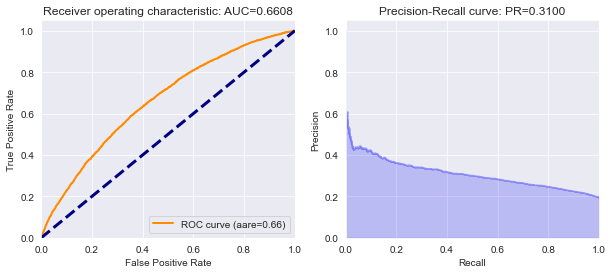

In [91]:
ROC_AUC(aml_v1,test_hex,'loan_default')

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



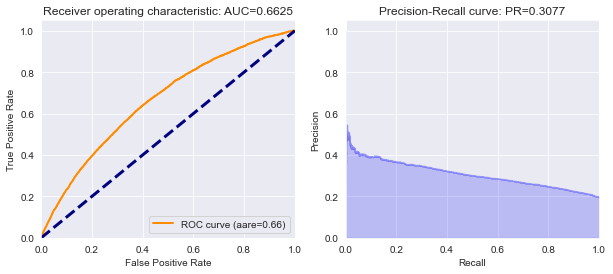

In [92]:
ROC_AUC(aml_v2,test_hex,'loan_default')

The first autoML produced an AUC value of 0.6608 and the second autoML produced an AUC of 0.6625. Comparing the AUCs, the second model has a slightly high score, which means that the second model performs better than the first one. Recall from GLM model, the AUC value was 0.6619, which means that it performed between two autoML. Looking at the precision-recall curve, the first autoML has PR=0.31 and second has PR=0.3077. Since high precision relates to a low false positive rate, and high recall relates to a low false negative rate, this graph shows that the first autoML performed slightly better than the second one.